In [ ]:
 # --- Cell 1: install useful libs (run once) ---
!pip install rapidfuzz --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.7 MB/s eta 0:00:00


In [ ]:
# --- Cell 2: imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process, fuzz
import os
from google.colab import files

In [ ]:
sns.set(style="whitegrid")
pd.set_option('display.max_columns', 200)

In [ ]:
# --- Cell 3: Upload your files ---
print("Upload the Chicago listings CSV file (insideairbnb 'listings.csv' for Chicago).")
uploaded = files.upload()   # choose the Chicago csv
# After that run again and upload the New Orleans csv, or upload both at once.

# List uploaded filenames
print("Uploaded files:", list(uploaded.keys()))

Upload the Chicago listings CSV file (insideairbnb 'listings.csv' for Chicago).


Saving listings.csv to listings.csv
Saving listings1.csv to listings1.csv
Uploaded files: ['listings.csv', 'listings1.csv']


In [ ]:
 # --- Cell 4: load files (adjust filenames if necessary) ---
# Replace these filenames if your upload names differ:
# If you uploaded both at once, pick the two files by name.
chicago_fname = [f for f in uploaded.keys() if "Chicago" in f or "chicago" in f.lower()]
nola_fname = [f for f in uploaded.keys() if "New" in f or "Orleans" in f or "neworleans" in f.lower()]

# if lists are empty, try to pick first two
if len(chicago_fname)==0 or len(nola_fname)==0:
    files_list = list(uploaded.keys())
    if len(files_list) >= 2:
        chicago_fname = [files_list[0]]
        nola_fname = [files_list[1]]
    else:
        raise Exception("Please upload two CSV files (Chicago and New Orleans).")

chicago_fname = chicago_fname[0]
nola_fname = nola_fname[0]

print("Using files:", chicago_fname, nola_fname)
df_ch = pd.read_csv(
    chicago_fname,
    encoding='latin1',
    sep=None,          # auto-detect delimiter
    engine='python',   # flexible parser
    on_bad_lines='skip'  # skip malformed rows
)

df_nola = pd.read_csv(
    nola_fname,
    encoding='latin1',
    sep=None,
    engine='python',
    on_bad_lines='skip'
)

Using files: listings.csv listings1.csv


In [ ]:
 # --- Cell 5: quick preview ---
print("Chicago rows:", df_ch.shape)
print("New Orleans rows:", df_nola.shape)
display(df_ch.columns.tolist()[:40])
df_ch.head(2)

Chicago rows: (7522, 79)
New Orleans rows: (30226, 4)


['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities']

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,19091,https://www.airbnb.com/rooms/19091,20250609011815,2025-06-17,city scrape,Fully Furnished Cozy Apartment,This cozy space is a wonder of post-Katrina re...,"NorthWest Carrollton, where this apartment is ...",https://a0.muscache.com/pictures/a5fdfd3b-5d81...,72880,https://www.airbnb.com/users/show/72880,John,2010-01-23,"New Orleans, LA",I recently (2018) retired as the Director of B...,within an hour,100%,100%,f,https://a0.muscache.com/im/users/72880/profile...,https://a0.muscache.com/im/users/72880/profile...,Riverbend,1,1,"['email', 'phone', 'work_email']",t,t,Neighborhood highlights,Leonidas,NaN,29.96100,-90.11950,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[""Books and reading material"", ""Dishes and sil...",$62.00,1,365,1,1,365,365,1.0,365.0,NaN,t,10,19,23,288,2025-06-17,504,1,0,126,0,10,620.0,2010-04-16,2025-03-07,4.89,4.95,4.87,4.97,4.98,4.68,4.91,"25-NSTR-11772, 25-OSTR-11151",f,1,1,0,0,2.73
1,71624,https://www.airbnb.com/rooms/71624,20250609011815,2025-06-17,city scrape,Ravenwood Manor (Historic Bywater),You are in for a very unique stay in a neighbo...,"Ours is a neighborhood made up of artists, mus...",https://a0.muscache.com/pictures/37488608/8cc1...,367223,https://www.airbnb.com/users/show/367223,Susan,2011-01-29,"New Orleans, LA",I am a decorative painter and faux finish arti...,NaN,NaN,47%,t,https://a0.muscache.com/im/users/367223/profil...,https://a0.muscache.com/im/users/367223/profil...,Bywater,1,2,"['email', 'phone']",t,t,Neighborhood highlights,Bywater,NaN,29.96153,-90.04364,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[""Dishes and silverware"", ""Heating"", ""Carbon m...",$150.00,30,1125,30,30,1125,1125,30.0,1125.0,NaN,t,30,60,90,356,2025-06-17,316,8,0,189,19,255,38250.0,2011-02-16,2025-05-07,4.94,4.92,4.93,4.98,4.98,4.84,4.89,"21-RSTR-18609, 22-OSTR-20720",f,1,1,0,0,1.81


In [ ]:
# --- Cell 6: standardize columns and keep relevant fields ---
keep_cols = [
    'id','name','host_id','host_name','neighbourhood_group','neighbourhood','latitude','longitude',
    'room_type','price','minimum_nights','number_of_reviews','last_review','reviews_per_month','availability_365',
    'calculated_host_listings_count','license'  # adjust if not present
]

def prepare_df(df, city_name):
    # pick columns that exist in file to avoid key errors
    cols = [c for c in keep_cols if c in df.columns]
    pdf = df[cols].copy()
    pdf = pdf.rename(columns={'id':'listing_id','neighbourhood_group':'neighbourhood_group',
                              'neighbourhood':'neighbourhood','room_type':'room_type','price':'price'})
    pdf['city'] = city_name
    return pdf

pdf_ch = prepare_df(df_ch, "Chicago")
pdf_nola = prepare_df(df_nola, "New Orleans")

In [ ]:

# --- Cell 7: concat into combined df ---
df = pd.concat([pdf_ch, pdf_nola], ignore_index=True, sort=False)
print("Combined dataset rows:", df.shape)
df.head(3)

Combined dataset rows: (37748, 17)


,listing_id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,calculated_host_listings_count,license,city
0,19091.0,Fully Furnished Cozy Apartment,72880.0,John,Neighborhood highlights,29.96100,-90.11950,Entire home/apt,$62.00,1.0,504.0,2025-03-07,2.73,288.0,1.0,"25-NSTR-11772, 25-OSTR-11151",Chicago
1,71624.0,Ravenwood Manor (Historic Bywater),367223.0,Susan,Neighborhood highlights,29.96153,-90.04364,Entire home/apt,$150.00,30.0,316.0,2025-05-07,1.81,356.0,1.0,"21-RSTR-18609, 22-OSTR-20720",Chicago
2,79536.0,FeelAtHomeInNewOrleans-PrivateApt,428362.0,Miriam,Neighborhood highlights,29.97803,-90.07450,Entire home/apt,NaN,3.0,781.0,2025-05-11,4.54,8.0,1.0,"23-NSTR-15067, 24-OSTR-20882",Chicago


In [ ]:


# --- Cell 8: cleaning basics ---
# convert price to numeric (strip $ and commas if present)
def clean_price(x):
    if pd.isna(x): return np.nan
    if isinstance(x, str):
        x = x.replace('$','').replace(',','').strip()
    try:
        return float(x)
    except:
        return np.nan

df['price'] = df['price'].apply(clean_price)
df['reviews_per_month'] = pd.to_numeric(df['reviews_per_month'], errors='coerce')
df['number_of_reviews'] = pd.to_numeric(df['number_of_reviews'], errors='coerce').fillna(0).astype(int)
df['minimum_nights'] = pd.to_numeric(df['minimum_nights'], errors='coerce').fillna(1).astype(int)
df['availability_365'] = pd.to_numeric(df['availability_365'], errors='coerce').fillna(0).astype(int)

# parse last_review to date
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')


In [ ]:
# --- Cell 9: derived columns ---
# price bins
df['price_bin'] = pd.cut(df['price'].fillna(0),
                         bins=[-1,50,100,200,400,1000, np.inf],
                         labels=["<50","50-100","100-200","200-400","400-1000",">1000"])

# availability category
def avail_cat(x):
    if x >= 300: return 'High (>=300)'
    if x >= 200: return 'Medium (200-299)'
    if x >= 100: return 'Low (100-199)'
    return 'Very Low (<100)'
df['availability_cat'] = df['availability_365'].apply(avail_cat)

# listing age (days since last_review) - approximate
df['days_since_last_review'] = (pd.Timestamp.today() - df['last_review']).dt.days


In [ ]:
# --- Cell 10: normalize neighbourhood values (simple) ---
# basic normalization: lowercase, strip
df['neighbourhood_clean'] = df['neighbourhood'].astype(str).str.lower().str.strip()

# advanced grouping example using RapidFuzz to merge similar names if needed
# build mapping for high-frequency neighbourhood names to canonical names
top_n = df['neighbourhood_clean'].value_counts().head(200).index.tolist()

# Example: find near matches for unique names (careful: costly for large lists)
# We'll create a simple mapping: exact lowercase => title case
df['neighbourhood_grouped'] = df['neighbourhood_clean'].str.title()


In [ ]:
# --- Cell 11: host type feature example ---
# create a simple host type: multi-listing host vs single-listing host
# we have a field 'calculated_host_listings_count' sometimes; if not, compute
if 'calculated_host_listings_count' in df.columns:
    df['host_listings_count'] = pd.to_numeric(df['calculated_host_listings_count'], errors='coerce').fillna(1).astype(int)
else:
    # compute from host_id occurrence
    if 'host_id' in df.columns:
        df['host_listings_count'] = df.groupby('host_id')['listing_id'].transform('count').fillna(1).astype(int)
    else:
        df['host_listings_count'] = 1

df['host_type'] = df['host_listings_count'].apply(lambda x: 'Multi-listing' if x>1 else 'Single-listing')

In [ ]:
# --- Cell 12: handle missing reviews_per_month (fill with 0) ---
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)


In [ ]:
# --- Cell 13: quick EDA aggregates (these will become sheets in Tableau) -- prints and saves CSVs for import ---
# 1. popular neighbourhoods (count + avg price)
neigh = df.groupby(['city','neighbourhood_grouped']).agg(
    listings_count=('listing_id','count'),
    avg_price=('price','mean'),
    avg_reviews=('number_of_reviews','mean'),
    avg_availability=('availability_365','mean')
).reset_index().sort_values(['city','listings_count'], ascending=[True,False])
display(neigh.head(10))

# 2. property / room type share
prop_share = df.groupby(['city', 'room_type']).size().reset_index(name='count')
prop_share['pct'] = prop_share.groupby('city')['count'].transform(lambda x: 100 * x / x.sum())
display(prop_share)

# 3. price distribution per city
price_stats = df.groupby('city')['price'].describe().reset_index()
display(price_stats)

# 4. host analysis summary
host_summary = df.groupby(['city','host_type']).agg(
    hosts=( 'host_id', 'nunique'),
    listings=('listing_id','count'),
    avg_price=('price','mean'),
    avg_reviews=('number_of_reviews','mean')
).reset_index()
display(host_summary)

,city,neighbourhood_grouped,listings_count,avg_price,avg_reviews,avg_availability
1,Chicago,Neighborhood Highlights,4414,770.232440,92.516765,209.64386
0,Chicago,Nan,3108,208.376466,27.566281,230.09009
2,New Orleans,Nan,0,NaN,0.000000,0.00000


,city,room_type,count,pct
0,Chicago,Entire home/apt,6474,86.067535
1,Chicago,Hotel room,117,1.555437
2,Chicago,Private room,924,12.283967
3,Chicago,Shared room,7,0.093060


,city,count,mean,std,min,25%,50%,75%,max
0,Chicago,6373.0,537.220461,3745.723911,16.0,90.0,135.0,223.0,50000.0
1,New Orleans,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,city,host_type,hosts,listings,avg_price,avg_reviews
0,Chicago,Multi-listing,919,4868,692.890398,59.666187
1,Chicago,Single-listing,2654,2654,221.143129,76.710625
2,New Orleans,Single-listing,0,0,NaN,0.000000


In [ ]:
 # --- Cell 14: save cleaned CSVs for Tableau import ---
out_dir = '/content/airbnb_outputs'
os.makedirs(out_dir, exist_ok=True)
df_ch_clean = df[df['city']=='Chicago'].copy()
df_nola_clean = df[df['city']=='New Orleans'].copy()

df_ch_clean.to_csv(os.path.join(out_dir,'airbnb_chicago_clean.csv'), index=False)
df_nola_clean.to_csv(os.path.join(out_dir,'airbnb_neworleans_clean.csv'), index=False)
df.to_csv(os.path.join(out_dir,'airbnb_combined_clean.csv'), index=False)

# also save the aggregates
neigh.to_csv(os.path.join(out_dir,'neighbourhood_summary.csv'), index=False)
prop_share.to_csv(os.path.join(out_dir,'roomtype_share.csv'), index=False)
price_stats.to_csv(os.path.join(out_dir,'price_stats.csv'), index=False)
host_summary.to_csv(os.path.join(out_dir,'host_summary.csv'), index=False)

print("Saved cleaned and aggregate CSVs to", out_dir)
# Provide a link to download zipped file (optional)
!zip -r /content/airbnb_outputs.zip /content/airbnb_outputs > /dev/null
files.download('/content/airbnb_outputs.zip')

Saved cleaned and aggregate CSVs to /content/airbnb_outputs


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

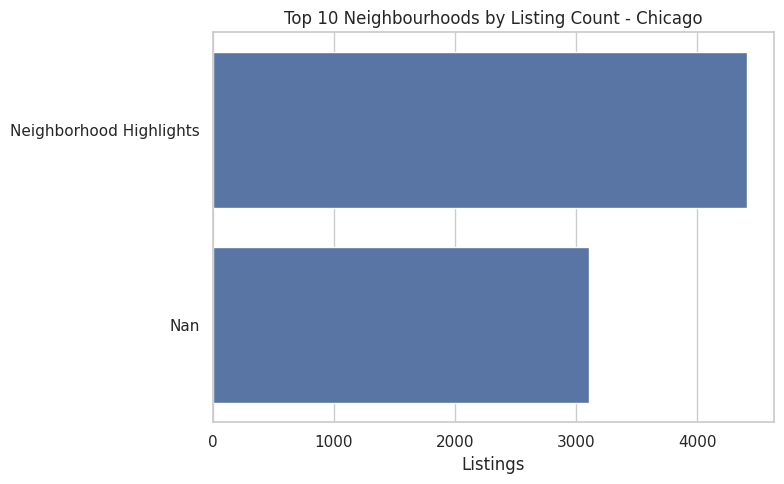

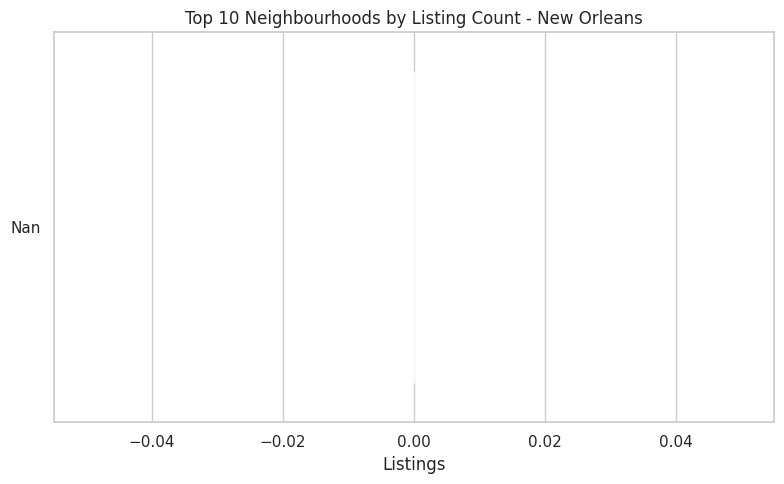

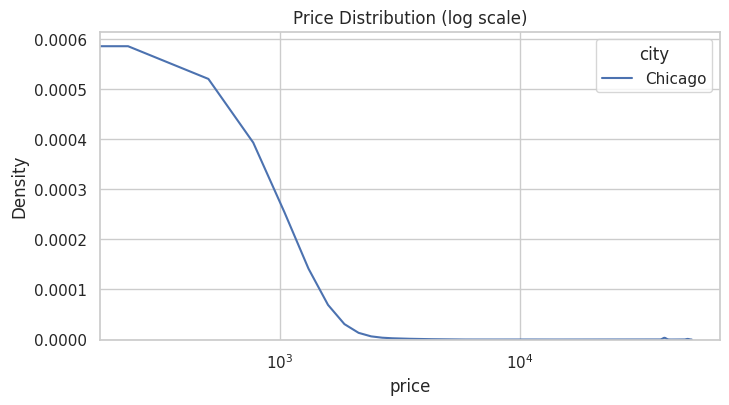

In [ ]:
   # --- Cell 15: Example plots ---
# Top 10 neighbourhoods by listings for each city
for city in df['city'].unique():
    topn = neigh[neigh['city']==city].nlargest(10,'listings_count')
    plt.figure(figsize=(8,5))
    sns.barplot(data=topn, x='listings_count', y='neighbourhood_grouped')
    plt.title(f"Top 10 Neighbourhoods by Listing Count - {city}")
    plt.xlabel("Listings")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

# Price distribution (log scale recommended)
plt.figure(figsize=(8,4))
sns.kdeplot(data=df[df['price']>0], x='price', hue='city', common_norm=False)
plt.xscale('log')
plt.title("Price Distribution (log scale)")
plt.show()

